# This is Chapter exrtaction

In [ ]:
import re
import json
import fitz  
FRONT_MATTER_STOPWORDS = {
    "contents", "table of contents", "copyright", "title page",
    "about the author", "dedication", "preface", "foreword", "acknowledgements",
}

def is_probable_chapter(title: str) -> bool:
    t = title.strip().lower()
    if t in FRONT_MATTER_STOPWORDS:
        return False

    if re.match(r"^\s*(chapter\s+\d+|[ivxlcdm]+\.)\b", t):  # "Chapter 1" or Roman numerals
        return True
    if re.match(r"^\s*\d+(\.\d+)*\b", t):  # "1", "1.2", "12.3.4"
        return True
    
    return len(title.strip()) >= 6

def load_toc(doc: fitz.Document):
    toc = doc.get_toc(simple=True)  # [[level, title, page], ...]
    clean = []
    for level, title, page in toc:
        if page is None or page < 1:
            continue  # skip missing/external links
        clean.append((level, title.strip(), page))
    return clean

def derive_chapter_ranges(doc: fitz.Document):
    """
    From full TOC -> list of canonical chapter entries with [start,end] page indices (0-based).
    Rule: chapter ends at the page before the next TOC item whose level <= this level.
    """
    toc = load_toc(doc)
    if not toc:
        return []

    level_counts = {}
    for level, title, _ in toc:
        if is_probable_chapter(title):
            level_counts[level] = level_counts.get(level, 0) + 1
    chapter_level = min(level_counts, key=lambda k: ( -level_counts[k], k )) if level_counts else 1

    filtered = [(lvl, title, page) for (lvl, title, page) in toc if lvl >= chapter_level]

    chapters = []
    for i, (lvl, title, page1_based) in enumerate(filtered):
        if lvl != chapter_level:
            continue
        start = max(0, page1_based - 1) 


        end_0based = doc.page_count - 1
        for j in range(i + 1, len(filtered)):
            lvl_j, _, page_j_1b = filtered[j]
            if lvl_j <= chapter_level:
                end_0based = max(0, page_j_1b - 2) 
                break

        if start <= end_0based:
            chapters.append({
                "level": lvl,
                "title": title,
                "start_page": start,
                "end_page": end_0based
            })

    chapters = [c for c in chapters if is_probable_chapter(c["title"])]
    return chapters

def extract_text_range(doc: fitz.Document, start_page: int, end_page: int) -> str:
    parts = []
    for p in range(start_page, end_page + 1):
        page = doc[p]
        parts.append(page.get_text("text", sort=True))
    return "\n".join(parts).strip()

# ---- Example usage ----
# if __name__ == "__main__":
#     path = r"C:\Users\amogh\Desktop\Project-Velcro\Books\The Inimitable Jeeves (P. G. Wodehouse) (Z-Library).pdf"
#     doc = fitz.open(path)
#     chapters = derive_chapter_ranges(doc)

#     for idx, ch in enumerate(chapters[:5]):
#         print(f"[{idx}] {ch['title']}  -> pages {ch['start_page']+1}–{ch['end_page']+1}")


[0] Chapter 1 – Jeeves Exerts the Old Cerebellum  -> pages 2–5
[1] Chapter 2 – No Wedding Bells for Bingo  -> pages 6–10
[2] Chapter 3 – Aunt Agatha Speaks her Mind  -> pages 11–13
[3] Chapter 4 – Pearls Mean Tears  -> pages 14–19
[4] Chapter 5 – The Pride of the Woosters is Wounded  -> pages 20–24


# First pass JSON structure

```jsonc
{
  "chapter": [{
    "chapter_id": 0,                // Chapter number
    "title": "",                    // Chapter title
    "pages": [0, 0],                // [start_page, end_page]
    "summary_local": "",            // <= 160 words
    "characters": [
      {
        "name": "",                 // Character name
        "aliases": [],
        "status": "",               // Character status
        "chapter_role": "",         // Role in this chapter
        "character_actions": "",
        "relationships": [
          {
            "with_name": "",        // Other character's name
            "type": "",             // Relationship type
            "justification": ""     // <= 30 words
          }
        ]
      }
    ]
  } 
  ]
}


In [ ]:
def make_chapter_skeletons(chapters):# Making the chapters strucutre
    out = []
    for chapter_id, ch in enumerate(chapters, start=1):
        out.append({
            "chapter_id": chapter_id,
            "title": ch["title"],
            "pages": [ch["start_page"], ch["end_page"]],
            "summary_local": "",
            "characters": [
                {
                    "name": "",
                    "aliases": [],
                    "status": "",
                    "chapter_role": "",
                    "character_actions": "",
                    "relationships": [
                        {"with_name": "", "type": "", "justification": ""}
                    ],
                }
            ],
        })
    return {"chapter": out}

# skeleton = make_chapter_skeletons(chapters)
# print(json.dumps(skeleton, indent=2))


In [ ]:
from typing import List
from pydantic import BaseModel, Field
from openai import OpenAI
from openai import AsyncOpenAI, RateLimitError, APIError, APIConnectionError, InternalServerError
import asyncio

client = AsyncOpenAI()

class Relationship(BaseModel):
    with_name: str = Field(..., description="Other character's name")
    type: str = Field(..., description="Relationship type (e.g., ally | mentor | antagonist | family | rival | colleague | unknown)")
    justification: str = Field(..., description="<= 50 words")

class Character(BaseModel):
    name: str = Field(..., description="Name of the character")
    aliases: List[str] = Field(..., description="List of aliases for the character")
    status: str = Field(..., description="e.g: active | missing | dead | resolved | tentative")
    chapter_role: str = Field(..., description="e.g: POV | supporting | antagonist | cameo | unknown")
    character_actions: str = Field(..., description="Key actions or events involving the character in this chapter. Be descriptive and use short hand (<= 100 words)")
    relationships: List[Relationship]

class ChapterFill(BaseModel):
    summary_local: str = Field(..., description="summary of the chapter in <= 160 words")
    characters: List[Character]

chapter_fill_prompt = "You are a library assistant who is skilled at extracting structured information from story book chapters. You are given the text of a chapter and must fill in the structured data fields, such that it meets the following criteria:" \
"1. The summary_local field must contain a concise summary of the chapter in the context of the data provided. Even if you are aware about the story you are dealing with, do not add additional information that can potentially spoil the future chapters, limited to 160 words.\n" \
"2. For the characters entry, it is a list of Character objects, each with the following fields:\n" \
"   - name: Name of the character\n" \
"   - aliases: List of aliases for the character. Do not include generic pronouns such as 'he', 'she', or 'they' or role words such as teacher, guard , protagonist , antagonist etc\n" \
"   - status: e.g: active | missing | dead | resolved | tentative\n" \
"   - chapter_role: e.g: POV | supporting | antagonist | cameo | unknown\n" \
"   - character_actions: Key actions or events involving the character in this chapter (<= 100 words)\n" \
"   - relationships: List of Relationship objects\n" \
"3. For the relationships entry, it is a list of Relationship objects, each with the following fields:\n" \
"   - with_name: Other character's name\n" \
"   - type: Relationship type (e.g., ally | mentor | antagonist | family | rival | colleague | unknown)\n" \
"   - justification: an explanation in the context of the chapter why the relationship exists ( <= 50 words)\n"

# def fill_chapter_with_model(chapter_text: str) -> ChapterFill:
#     system = chapter_fill_prompt
#     resp = client.responses.parse(
#         model="gpt-5-mini",
#         input=[
#             {"role": "system", "content": system},
#             {"role": "user", "content": chapter_text},
#         ],
#         text_format=ChapterFill,
#     )
#     return resp.output_parsed

async def fill_chapter_with_model_async(client: AsyncOpenAI, chapter_text: str, *, semaphore: asyncio.Semaphore,
                                        max_retries: int = 5) -> ChapterFill:
    backoff = 1
    for attempt in range(max_retries):
        try:
            async with semaphore:
                resp = await client.responses.parse(
                    model="gpt-5-mini",
                    input=[
                        {"role": "system", "content": chapter_fill_prompt},
                        {"role": "user", "content": chapter_text},
                    ],
                    text_format=ChapterFill,
                )
            return resp.output_parsed
        except (RateLimitError, APIError, APIConnectionError, InternalServerError) as e:
            if attempt == max_retries - 1:
                raise
            await asyncio.sleep(backoff + random.random())
            backoff = min(backoff * 2, 30)


In [35]:
chapters

[{'level': 2,
  'title': '1 Here Comes Charlie',
  'start_page': 11,
  'end_page': 17},
 {'level': 2,
  'title': "2 Mr Willy Wonka's Factory",
  'start_page': 18,
  'end_page': 21},
 {'level': 2,
  'title': '3 Mr Wonka and the Indian Prince',
  'start_page': 22,
  'end_page': 24},
 {'level': 2,
  'title': '4 The Secret Workers',
  'start_page': 25,
  'end_page': 28},
 {'level': 2,
  'title': '5 The Golden Tickets',
  'start_page': 29,
  'end_page': 30},
 {'level': 2,
  'title': '6 The First Two Finders',
  'start_page': 31,
  'end_page': 35},
 {'level': 2,
  'title': "7 Charlie's Birthday",
  'start_page': 36,
  'end_page': 38},
 {'level': 2,
  'title': '8 Two More Golden Tickets Found',
  'start_page': 39,
  'end_page': 42},
 {'level': 2,
  'title': '9 Grandpa Joe Takes a Gamble',
  'start_page': 43,
  'end_page': 44},
 {'level': 2,
  'title': '10 The Family Begins to Starve',
  'start_page': 45,
  'end_page': 50},
 {'level': 2, 'title': '11 The Miracle', 'start_page': 51, 'end_page':

In [ ]:
# def process_all_chapters(doc: fitz.Document, chapters: list) -> dict:
#     """
#     Processes all chapters, fills them with AI-generated data, and returns the final JSON object.
#     """
#     final_data = make_chapter_skeletons(chapters)
    
#     for i, chapter_info in enumerate(final_data["chapter"]):
#         print(f"Processing Chapter {chapter_info['chapter_id']}: '{chapter_info['title']}'...")
        
#         start_page, end_page = chapter_info["pages"]
#         chapter_text = extract_text_range(doc, start_page, end_page)
        
#         if not chapter_text.strip():
#             print(f"  -> No text found for chapter {chapter_info['chapter_id']}. Skipping.")
#             continue

#         # Get structured data from the AI model
#         filled_data = fill_chapter_with_model(chapter_text)
        
#         # Update the final JSON structure
#         final_data["chapter"][i]["summary_local"] = filled_data.summary_local
#         # Convert Pydantic character models to dictionaries for JSON serialization
#         final_data["chapter"][i]["characters"] = [char.model_dump() for char in filled_data.characters]

#     return final_data


async def process_all_chapters_async(doc: fitz.Document, chapters: list, max_concurrency: int = 4) -> dict:
    extracted = []
    for ch in chapters:
        text = extract_text_range(doc, ch["start_page"], ch["end_page"])
        extracted.append({"meta": ch, "text": text})

    final_data = make_chapter_skeletons(chapters)

    aclient = AsyncOpenAI()
    sem = asyncio.Semaphore(max_concurrency)

    tasks = []
    index_map = []  
    for i, item in enumerate(extracted):
        if not item["text"].strip():
            continue
        print(f"Processing Chapter {item['meta']['chapter_id']}...")
        tasks.append(asyncio.create_task(
            fill_chapter_with_model_async(aclient, item["text"], semaphore=sem)
        ))
        index_map.append(i)

    results = await asyncio.gather(*tasks, return_exceptions=True)

    for task_idx, result in enumerate(results):
        i = index_map[task_idx]
        if isinstance(result, Exception):
            # Leave defaults for this chapter (or you could add an "error" field)
            print(f"Chapter {final_data['chapter'][i]['chapter_id']} failed: {result}")
            continue

        final_data["chapter"][i]["summary_local"] = result.summary_local
        final_data["chapter"][i]["characters"] = [c.model_dump() for c in result.characters]

    return final_data

#### Look into parallel processing for chapter extraction , taking too long. ✅ (Done: 20 minutes to 4 minutes)

In [22]:
# pdf_path = r"C:\\Users\\abiju\\Desktop\\Project-Velcro\\REference_textbook\\Charlie and the Chocolate Factory (Roald Dahl).pdf"
# doc = fitz.open(pdf_path)

# chapters = derive_chapter_ranges(doc)
# if not chapters:
#     print("No chapters were derived from the PDF's table of contents.")
# else:
#     print("\n--- PROCESSING ALL CHAPTERS ---")
#     # final_output = process_all_chapters(doc, chapters)
#     final_output = asyncio.run(process_all_chapters_async(doc, chapters, max_concurrency=4))
#     output_filename = "final_story_output.json"
#     with open(output_filename, "w") as f:
#         json.dump(final_output, f, indent=2)
        
#     print(f"\nProcessing complete. The final JSON object has been saved to '{output_filename}'")


--- PROCESSING ALL CHAPTERS ---


RuntimeError: asyncio.run() cannot be called from a running event loop

In [ ]:
pdf_path = r"C:\Users\abiju\Desktop\Project-Velcro\REference_textbook\Charlie and the Chocolate Factory (Roald Dahl).pdf"
doc = fitz.open(pdf_path)

chapters = derive_chapter_ranges(doc)
if not chapters:
    print("No chapters were derived from the PDF's table of contents.")
else:
    print("\n--- PROCESSING ALL CHAPTERS ---")
    final_output = await process_all_chapters_async(doc, chapters, max_concurrency=4)

    output_filename = "final_story_output.json"
    with open(output_filename, "w") as f:
        json.dump(final_output, f, indent=2)

    print(f"\nProcessing complete. The final JSON object has been saved to '{output_filename}'")

doc.close()



--- PROCESSING ALL CHAPTERS ---

Processing complete. The final JSON object has been saved to 'final_story_output.json'


# Seconds pass : Now we connect between the chapters

```jsonc
{
  "chapter": [{
    "chapter_id": 0,                // Chapter number
    "title": "",                    // Chapter title
    "pages": [0, 0],                // [start_page, end_page]
    "summary_local": "",            // <= 160 words 
    "summary_global": "",           // concatenated summary across chapters ≤ 250 words
    "characters": [
      {
        "name": "",                 // Character name
        "aliases": [],              // Concatenated aliases across all the chapters
        "status": "",               // Update the character status as the story and relationships evolve
        "chapter_role": "",         // Current role in the chapter in the context of the ongoing story 
        "character_actions": "",  // Key actions or events involving the character as the story is progressing (<= 150 words)
        "relationships": [
          {
            "with_name": "",        // Other character's name
            "type": "",             // Updated Relationship type as the story progresses and the relationships evolve
            "justification": "",    // Updated in the context of the story <= 100 words
            "importance": 0         // Updated importance level (0-5)
          }
        ]
      }
    ]
  } 
  ]
}


In [17]:
from typing import List, Dict, Any

class RelationshipGlobal(BaseModel):
    with_name: str
    type: str
    justification: str = Field(..., description="<= 100 words")
    importance: int = Field(..., description="0-5 scale")

class CharacterGlobal(BaseModel):
    name: str
    aliases: List[str]
    status: str
    chapter_role: str
    character_actions: str = Field(..., description="Key actions or events involving the character in the ongoing story. Be descriptive and use short hand <= 200 words")
    relationships: List[RelationshipGlobal]

class ChapterGlobal(BaseModel):
    summary_global: str = Field(..., description="summary of the ongoing story <= 250 words")
    characters: List[CharacterGlobal]

In [40]:
# def merge_characters_locally(existing_chars: Dict[str, dict], new_chars: List[dict]) -> Dict[str, dict]:

#     for char in new_chars:
#         name = char['name']
        
#         matched_name = None
#         for alias in char.get('aliases', []):
#             for existing_name in existing_chars:
#                 if alias == existing_name or alias in existing_chars[existing_name].get('aliases', []):
#                     matched_name = existing_name
#                     break
#             if matched_name:
#                 break
        
#         key = matched_name or name
        
#         if key in existing_chars:
#             existing_aliases = set(existing_chars[key].get('aliases', []))
#             new_aliases = set(char.get('aliases', []))
#             existing_chars[key]['aliases'] = list(existing_aliases | new_aliases)
            
#             existing_chars[key]['status'] = char['status']
#             existing_chars[key]['chapter_role'] = char['chapter_role']
#             existing_chars[key]['character_actions'] = char['character_actions']
#             existing_chars[key]['relationships'] = char['relationships']
#         else:
#             # Add new character
#             existing_chars[key] = char.copy()
    
#     return existing_chars

In [41]:
chapter_fill_global = """
You are a library assistant who is skilled at extracting structured information from story book chapters. You are given the text of a chapter and must fill in the structured data fields, such that it meets the following criteria:
1. The summary_global field must contain a concise summary of the ongoing story in the context of the previous chapter summary and current chapter summary provided. Even if you are aware about the story you are dealing with, do not add additional information that can potentially spoil the future chapters, limited to 250 words.
2. The characters field must include all relevant characters introduced or developed in the chapter, along with their updated attributes. This includes :
   - Name: Name of the character
   - Aliases: List of character aliases
   - Status: Current status of the character in the context of the ongoing story with reference to previous chapters and current chapter
   - Chapter role: Role of the character in the chapter in the context of the ongoing story
   - Character actions: Key actions or events involving the character in the ongoing story
   - Relationships: List of relationships with other characters
3. For the relationships field, it is a list of Relationship objects, each with the following fields:
    - with_name: Other character's name
    - type: Relationship type (e.g., ally | mentor | antagonist | family | rival | colleague | unknown)
    - justification: an explanation in the context of the chapter why the relationship exists ( <= 100 words)
    - importance: Importance of the relationship on a scale of 0-5, where 0 is negligible and 5 is critical to the story. Update the importance level as the story progresses.
"""


In [ ]:
async def create_global_view(
    client: AsyncOpenAI,
    previous_summary: str,
    previous_characters: dict,   # dict[str, dict] — your cumulative state
    current_chapter: dict        # from first pass
) :
    context = {
        "previous_story_summary": previous_summary,
        "all_known_characters_so_far": list(previous_characters.values()),
        "current_chapter_title": current_chapter["title"],
        "current_chapter_summary": current_chapter["summary_local"],
        "characters_in_current_chapter": current_chapter["characters"],
    }

    resp = await client.responses.parse(
        model="gpt-5-mini",
        input=[
            {"role": "system", "content": chapter_fill_global},
            {"role": "user", "content": json.dumps(context, indent=2)}
        ],
        text_format=ChapterGlobal,
    )
    # Correctly returns the parsed Pydantic model
    return resp.output_parsed

In [ ]:
def _normalize_and_validate_global(ch: ChapterGlobal): # Essentially normalization
    if not ch or not ch.characters:
        return ch

    for c in ch.characters:
        # Normalize and deduplicate aliases
        seen_aliases = set()
        unique_aliases = []
        for alias in (c.aliases or []):
            stripped_alias = (alias or "").strip()
            if stripped_alias and stripped_alias.lower() not in seen_aliases:
                seen_aliases.add(stripped_alias.lower())
                unique_aliases.append(stripped_alias)
        c.aliases = unique_aliases

        # Validate relationships
        if not c.relationships:
            continue
        for r in c.relationships: # Fixing edge case hallucination
            r.importance = max(0, min(5, int(r.importance or 0)))
            if r.justification and len(r.justification.split()) > 100:
                r.justification = " ".join(r.justification.split()[:100]) + "..."
    return ch


In [ ]:
async def second_pass_processing(client: AsyncOpenAI, first_pass_data: dict) -> dict:
    chapters = first_pass_data["chapter"]
    final_output = {"chapter": []}

    # Initialize cumulative state
    cumulative_summary = ""
    cumulative_characters = {}   # {canonical_name: character_dict}
    alias_index = {}             # {normalized_alias: canonical_name}

    for i, chapter_data in enumerate(chapters, start=1):
        print(f"Second Pass - Processing chapter {i}/{len(chapters)}: {chapter_data['title']}")

        # 1. Get the intelligently merged view from the LLM
        global_view = await create_global_view(
            client=client,
            previous_summary=cumulative_summary,
            previous_characters=cumulative_characters,
            current_chapter=chapter_data
        )

        # 2. Apply guardrails: normalize and validate the LLM's output
        validated_global_view = _normalize_and_validate_global(global_view)

        # 3. Update the cumulative state using the *validated* data
        cumulative_summary = validated_global_view.summary_global
        
        # Reset and rebuild the character dictionary and alias index from the new ground truth
        cumulative_characters = {}
        alias_index = {}
        
        for char_model in validated_global_view.characters:
            char_dict = char_model.model_dump()
            canonical_name = char_model.name
            
            cumulative_characters[canonical_name] = char_dict
            
            # Update the alias index for robust tracking
            norm_canon_name = canonical_name.strip().casefold()
            alias_index[norm_canon_name] = canonical_name
            for alias in char_model.aliases:
                alias_index[alias.strip().casefold()] = canonical_name

        # 4. Append the state *as of this chapter* to the final output
        final_output["chapter"].append({
            "chapter_id": chapter_data["chapter_id"],
            "title": chapter_data["title"],
            "pages": chapter_data["pages"],
            "summary_local": chapter_data["summary_local"],
            "summary_global": cumulative_summary,
            "characters": list(cumulative_characters.values()),
        })

    return final_output

In [46]:
async def main():
    try:
        with open("final_story_output.json", "r") as f:
            first_pass_data = json.load(f)

        client = AsyncOpenAI()

        print("\n--- STARTING SECOND PASS PROCESSING ---")
        second_pass_output = await second_pass_processing(client, first_pass_data)

        output_filename = "story_global_view.json"
        with open(output_filename, "w") as f:
            json.dump(second_pass_output, f, indent=2)

        print(f"\nSecond pass complete! Saved to '{output_filename}'")

    except FileNotFoundError:
        print("Error: 'final_story_output.json' not found. Please run the first pass script first.")
    except Exception as e:
        print(f"An error occurred: {e}")

if __name__ == "__main__":
    await main()


--- STARTING SECOND PASS PROCESSING ---
Second Pass - Processing chapter 1/30: 1 Here Comes Charlie
Second Pass - Processing chapter 2/30: 2 Mr Willy Wonka's Factory
Second Pass - Processing chapter 3/30: 3 Mr Wonka and the Indian Prince
Second Pass - Processing chapter 4/30: 4 The Secret Workers
Second Pass - Processing chapter 5/30: 5 The Golden Tickets
Second Pass - Processing chapter 6/30: 6 The First Two Finders
Second Pass - Processing chapter 7/30: 7 Charlie's Birthday
Second Pass - Processing chapter 8/30: 8 Two More Golden Tickets Found
Second Pass - Processing chapter 9/30: 9 Grandpa Joe Takes a Gamble
Second Pass - Processing chapter 10/30: 10 The Family Begins to Starve
Second Pass - Processing chapter 11/30: 11 The Miracle
Second Pass - Processing chapter 12/30: 12 What It Said on the Golden Ticket
Second Pass - Processing chapter 13/30: 13 The Big Day Arrives
Second Pass - Processing chapter 14/30: 14 Mr Willy Wonka
Second Pass - Processing chapter 15/30: 15 The Chocolat

## TODO: Make a more efficient second pass: Fool around with sliding window

## Building RAG agent which will combine the JSON output we generated and use semantic search

#### So this is going to be a chat interface between the user and the RAG agent. RAG agent will take user queries, take meta data about the current page / status of the chapter the user is currently in, and then use that information to generate queries to the underlying document store. It should be capable of generating sub queries to get more granular information from the document store and then stitch together the appropriate reponse.

In [1]:
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.vectorstores import InMemoryVectorStore
import getpass
import os

file_path = r"C:\Users\abiju\Desktop\Project-Velcro\REference_textbook\Chocolate.pdf"
loader = PyPDFLoader(file_path)

docs = loader.load()

print(len(docs))

56


In [2]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000, chunk_overlap=200, add_start_index=True
)
all_splits = text_splitter.split_documents(docs)

len(all_splits)

245

In [3]:
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

In [4]:
vector_store = InMemoryVectorStore(embeddings)
ids = vector_store.add_documents(documents=all_splits)

In [13]:
results = vector_store.similarity_search(
    "Give me the song sung for Violet Beauregarde"
)

i =0
for r in results:
    print(i)
    i+=1
    print(r)
    print("*******************************************************************")

0
page_content='Thereafter, just from chewing gum, 
Miss Bigelow was always dumb, 
And spent her life shut up in some 
Disgusting sanatorium. 
And that is why we'll try so hard 
To save Miss Violet Beauregarde 
From suffering an equal fate. 
She's still quite young. It's not too late, 
Provided she survives the cure. 
We hope she does. We can't be sure.' 
  
22 
Along the Corridor 
 
  'Well, well, well,' sighed Mr Willy Wonka, 'two naughty little children gone. Three good 
little children left. I think we'd better get out of this room quickly before we lose anyone else!' 
  'But Mr Wonka,' said Charlie Bucket anxiously, 'will Violet Beauregarde ever be all right 
again or will she always be a blueberry?' 
  'They'll de-juice her in no time flat!' declare d Mr Wonka. 'They'll roll her into the de-juicing 
machine, and she'll come out just as thin as a whistle!' 
  'But will she still be blue all over?' asked Charlie.' metadata={'producer': 'Acrobat Distiller 7.0 (Windows)', 'creator': 

## Building the Agent


In [ ]:
import os, getpass
from langchain_openai import ChatOpenAI
from typing import List
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import MessagesState
from typing import  Annotated
import operator
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from IPython.display import Image, display
from langchain_core.messages import get_buffer_string
from langchain_core.documents import Document



''' 
Basic flow: User Query -> (Splits)-> Sematic Seartch & Current Chapter Sumamry and Relationships -> Library Assistant LLM (Reason) -> either Answer or Refine the Query (Ask for more context) -> (if refine, loop back to Search) -> Prodfuce Final Answer
'''
class SearchQuery(BaseModel):
    query : str

llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

class StoryState(MessagesState):
    curr_page: int 
    curr_chapter_id
    max_num_turns: int # Number turns of research
    context: Annotated[list, operator.add] # Source docs
    interview: str # Interview transcript

In [ ]:
import os
import json
from typing import List, Dict, Any
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.documents import Document
from IPython.display import Image, display
import operator


llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

class StoryState(TypedDict):
    messages: Annotated[List , operator.add]  # Conversation history
    curr_page: int  # Reader's current page
    curr_chapter_id: int  # Current chapter ID
    iteration_count: int  # Track refinement iterations
    max_iterations: int  # Maximum allowed iterations
    question: str  # Current question being processed
    chapter_context: dict  # Current chapter information
    retrieved_docs: List[Document]  # Semantic search results

# ============= Pydantic Models =============
class SearchQuery(BaseModel):
    """Model for structured search query generation"""
    query: str = Field(..., description="Refined search query")

# ============= Node Functions =============

def initialize_question(state: StoryState) -> Dict:
    """Extract the initial question from the user's message"""
    if state.get("messages"):
        question = state["messages"][-1].content
        return {
            "question": question,
            "iteration_count": 0,
            "max_iterations": 3  # Set default max iterations
        }
    return {}

def get_current_chapter_context(state: StoryState) -> Dict:
    """Fetch the current chapter context based on reader's page"""
    curr_page = state.get("curr_page", 0)
    
    try:
        with open("story_global_view.json", "r") as f:
            story_data = json.load(f)
        
        # Find the chapter containing the current page
        for chapter in story_data.get("chapter", []):
            start_page, end_page = chapter.get("pages", [-1, -1])
            if start_page <= curr_page <= end_page:
                return {
                    "chapter_context": chapter,
                    "curr_chapter_id": chapter.get("chapter_id", 0)
                }
        
        # Fallback to first chapter if no match
        if story_data.get("chapter"):
            return {
                "chapter_context": story_data["chapter"][0],
                "curr_chapter_id": story_data["chapter"][0].get("chapter_id", 1)
            }
    
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Warning: Could not load story data: {e}")
    
    return {"chapter_context": {}, "curr_chapter_id": 0}

def semantic_search(state: StoryState) -> Dict:
    query = state.get("question", "")
    curr_page = state.get("curr_page", 0)
    
    if not query:
        return {"retrieved_docs": []}
    
    # Determine the maximum allowed page (spoiler boundary)
    max_allowed_page = -1
    try:
        with open("story_global_view.json", "r") as f:
            story_data = json.load(f)
        
        for chapter in story_data.get("chapter", []):
            start_page, end_page = chapter.get("pages", [-1, -1])
            if start_page <= curr_page <= end_page:
                max_allowed_page = end_page
                break
    
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Warning: Could not determine spoiler boundary: {e}")
        return {"retrieved_docs": []}
    
    if max_allowed_page == -1:
        print(f"Warning: Could not find chapter for page {curr_page}")
        return {"retrieved_docs": []}
    
    try:
        unfiltered_results = vector_store.similarity_search(query, k=10)
        
        filtered_results = []
        for doc in unfiltered_results:
            doc_page = doc.metadata.get("page")
            if doc_page is not None and doc_page <= max_allowed_page:
                filtered_results.append(doc)
        
        # Return top 4 filtered results
        final_results = filtered_results[:4]
        
        print(f"Search query: '{query}'")
        print(f"Found {len(unfiltered_results)} results, filtered to {len(final_results)} spoiler-free results")
        
        return {"retrieved_docs": final_results}
    
    except NameError:
        print("Warning: vector_store not defined. Returning empty results.")
        return {"retrieved_docs": []}

def generate_answer_or_refine(state: StoryState) -> Dict:
    
    chapter_context = state.get("chapter_context", {})
    retrieved_docs = state.get("retrieved_docs", [])
    question = state.get("question", "")
    iteration_count = state.get("iteration_count", 0)
    max_iterations = state.get("max_iterations", 3)
    
    # Force final answer if we've hit max iterations
    if iteration_count >= max_iterations:
        print(f"Max iterations ({max_iterations}) reached. Generating final answer.")
        return generate_final_answer(state)
    
    # Prepare context for the LLM
    prompt = """You are an expert library assistant specializing in helping readers understand stories without spoilers.

**Current Chapter Information:**
Title: {chapter_title}
Summary: {chapter_summary}
Characters: {chapter_characters}

**Retrieved Information from Book:**
{search_results}

**Reader's Question:**
{question}

**Your Task:**
Analyze if you have sufficient information to provide a complete, accurate answer.

**Decision Rules:**
1. If you can answer the question completely and accurately with the available information:
   - Provide a clear, helpful response
   - Base your answer ONLY on the provided context
   - Never make up information

2. If you need more specific information:
   - Start your response with exactly: "NEED_MORE_CONTEXT:"
   - Follow with a single, specific search query that would help find the missing information
   - Make the query focused and relevant to what's missing

**Remember:**
- Never reference future chapters or events (spoilers)
- Be conversational and helpful
- If information is partially available, provide what you can
"""
    
    # Format search results
    search_results_text = "\n\n".join([
        f"[Page {doc.metadata.get('page', 'Unknown')}]: {doc.page_content[:300]}..."
        for doc in retrieved_docs
    ]) if retrieved_docs else "No relevant passages found in the book."
    
    # Format chapter information
    chapter_title = chapter_context.get("title", "Unknown")
    chapter_summary = chapter_context.get("summary_global", chapter_context.get("summary_local", "Not available"))
    
    # Format characters (limit to avoid token overflow)
    characters = chapter_context.get("characters", [])
    chapter_characters = ", ".join([
        char.get("name", "Unknown") for char in characters[:5]
    ]) if characters else "No characters listed"
    
    # Invoke LLM
    response = llm.invoke([
        SystemMessage(content=prompt.format(
            chapter_title=chapter_title,
            chapter_summary=chapter_summary,
            chapter_characters=chapter_characters,
            search_results=search_results_text,
            question=question
        ))
    ])
    
    return {
        "messages": [AIMessage(content=response.content)],
        "iteration_count": iteration_count + 1
    }

def generate_final_answer(state: StoryState) -> Dict:
    """
    Generate the final answer when forced (max iterations reached)
    """
    prompt = """You are a helpful library assistant. Based on the available information, provide the best answer you can to the reader's question.

**Available Information:**
Chapter: {chapter_title}
Summary: {chapter_summary}
Retrieved passages: {search_results}

**Question:** {question}

Provide a helpful response based ONLY on the available information. If some aspects cannot be answered, clearly state what you can and cannot answer.
"""
    
    chapter_context = state.get("chapter_context", {})
    retrieved_docs = state.get("retrieved_docs", [])
    
    search_results_text = "\n".join([
        f"- {doc.page_content[:200]}..." for doc in retrieved_docs[:3]
    ]) if retrieved_docs else "No specific passages available."
    
    response = llm.invoke([
        SystemMessage(content=prompt.format(
            chapter_title=chapter_context.get("title", "Unknown"),
            chapter_summary=chapter_context.get("summary_local", "Not available"),
            search_results=search_results_text,
            question=state.get("question", "")
        ))
    ])
    
    return {"messages": [AIMessage(content=f"Based on the information available: {response.content}")]}

def extract_refined_query(state: StoryState) -> Dict:
    """
    Extract the refined query from the AI's response when more context is needed
    """
    last_message = state["messages"][-1].content
    
    if "NEED_MORE_CONTEXT:" in last_message:
        # Extract the query after the marker
        parts = last_message.split("NEED_MORE_CONTEXT:", 1)
        if len(parts) > 1:
            new_query = parts[1].strip()
            return {"question": new_query}
    
    # Fallback: use original question
    return {}

# ============= Routing Functions =============

def decision_router(state: StoryState) -> str:
    """
    Determine whether to refine the search or provide final answer
    """
    if not state.get("messages"):
        return "final_answer"
    
    last_message = state["messages"][-1].content
    iteration_count = state.get("iteration_count", 0)
    max_iterations = state.get("max_iterations", 3)
    
    # Check if max iterations reached
    if iteration_count >= max_iterations:
        print(f"Max iterations ({max_iterations}) reached. Routing to final answer.")
        return "final_answer"
    
    # Check if more context is needed
    if "NEED_MORE_CONTEXT:" in last_message:
        print(f"Iteration {iteration_count}: Refining search")
        return "refine_search"
    
    return "final_answer"

# ============= Graph Construction =============

def build_interview_graph():
    """
    Construct the optimized LangGraph RAG pipeline
    """
    # Initialize the graph with our state
    builder = StateGraph(StoryState)
    
    # Add all nodes
    builder.add_node("initialize_question", initialize_question)
    builder.add_node("get_chapter_context", get_current_chapter_context)
    builder.add_node("semantic_search", semantic_search)
    builder.add_node("generate_answer_or_refine", generate_answer_or_refine)
    builder.add_node("extract_refined_query", extract_refined_query)
    
    # Define the flow
    # 1. Start by initializing the question
    builder.add_edge(START, "initialize_question")
    
    # 2. Then get chapter context (only once)
    builder.add_edge("initialize_question", "get_chapter_context")
    
    # 3. Perform initial semantic search
    builder.add_edge("get_chapter_context", "semantic_search")
    
    # 4. Generate answer or request refinement
    builder.add_edge("semantic_search", "generate_answer_or_refine")
    
    # 5. Conditional routing based on the response
    builder.add_conditional_edges(
        "generate_answer_or_refine",
        decision_router,
        {
            "refine_search": "extract_refined_query",
            "final_answer": END
        }
    )
    
    # 6. If refining, extract query and search again
    builder.add_edge("extract_refined_query", "semantic_search")
    
    # Compile with memory
    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)
    
    return graph

# ============= Usage Example =============

if __name__ == "__main__":
    # Build the graph
    interview_graph = build_interview_graph()
    
    # Visualize the graph
    # try:
    #     display(Image(interview_graph.get_graph().draw_mermaid_png()))
    # except Exception as e:
    #     print(f"Could not display graph: {e}")
    display(Image(interview_graph.get_graph().draw_mermaid_png()))
    # Example usage
    initial_state = {
        "messages": [HumanMessage(content="Who is Charlie and why is he important?")],
        "curr_page": 42,  # Example: reader is on page 42
        "max_iterations": 3
    }
    
    # Run the graph
    config = {"configurable": {"thread_id": "story_thread_001"}}
    
    # Note: This will fail without vector_store defined
    # result = interview_graph.invoke(initial_state, config)
    # print("Final Answer:", result["messages"][-1].content)

Search query: 'Who is Charlie and why is he important?'
Found 10 results, filtered to 4 spoiler-free results
Final Answer: Charlie is Charlie Bucket — one of the five children listed in the book and described as "the hero." In this chapter he’s important because his family’s hopes rest on him: he got a Wonka bar for his birthday (but no Golden Ticket), two other tickets have just been claimed, and only one ticket remains unclaimed. The chapter stresses the Buckets’ quiet support for Charlie and raises the stakes for him as the possible finder of the final ticket.


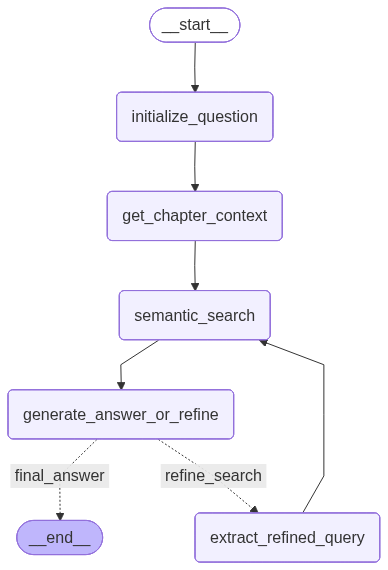

Found chapter: 8 Two More Golden Tickets Found for page 42
Spoiler boundary set to page 42
Search query: 'What was the song sung for Violet?'
Found 10 results, filtered to 4 spoiler-free results
Iteration 1: Have content from 3 unique pages
Answer provided, routing to end
Assistant: The song is a short cautionary ditty warning about the fate of "Miss Bigelow" from chewing gum and urging that they try to save Violet Beauregarde. From the provided pages it includes lines like:

- "Thereafter, just from chewing gum, Miss Bigelow was always dumb,  
And spent her life shut up in some  
Disgusting sanatorium."

and

- "And that is why we'll try so hard  
To save Miss Violet Beauregarde  
From suffering an equal fate.  
She's still quite young. It's not too late,  
Provided she survives the cur..."

I don't have the full lyrics or a title for the song in the pages you provided. Would you like me to look up the complete wording?

Total unique documents retrieved: 4


In [ ]:
import os
import json
from typing import List, Dict, Any, Annotated
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from langgraph.graph import START, END, StateGraph
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
from langchain_core.documents import Document
from IPython.display import Image, display
import operator

# Initialize LLM
llm = ChatOpenAI(model="gpt-5-mini", temperature=0)

def deduplicate_docs(existing: List[Document], new: List[Document]) -> List[Document]:
    if not existing:
        return new
    
    seen = set()
    for doc in existing:
        page = doc.metadata.get("page", -1)
        # Use first 200 chars for hash to identify unique content
        content_hash = hash(doc.page_content[:200]) if doc.page_content else 0
        seen.add((page, content_hash))
    
    unique_new = []
    for doc in new:
        page = doc.metadata.get("page", -1)
        content_hash = hash(doc.page_content[:200]) if doc.page_content else 0
        if (page, content_hash) not in seen:
            unique_new.append(doc)
            seen.add((page, content_hash))
    
    return existing + unique_new

class StoryState(TypedDict):
    messages: Annotated[List, operator.add]  
    curr_page: int 
    curr_chapter_id: int  
    iteration_count: int  
    max_iterations: int  
    question: str  
    chapter_context: dict  
    retrieved_docs: Annotated[List[Document], deduplicate_docs]  


class SearchQuery(BaseModel):
    query: str = Field(..., description="Clear, focused search query for finding information in the book")



def initialize_question(state: StoryState) -> Dict:
    if state.get("messages"):
        for msg in reversed(state["messages"]):
            if isinstance(msg, HumanMessage):
                return {
                    "question": msg.content,
                    "iteration_count": 0,
                    "max_iterations": state.get("max_iterations", 3),
                    "retrieved_docs": []  # Start fresh for new question
                }
    return {
        "iteration_count": 0,
        "max_iterations": 3
    }

def get_current_chapter_context(state: StoryState) -> Dict:
    curr_page = state.get("curr_page", 0)
    

    with open("story_global_view.json", "r") as f:
        story_data = json.load(f)
    
    chapters_list = story_data.get("chapter", [])
    
    if not chapters_list:
        print("Warning: No chapters found in story_global_view.json")
        return {"chapter_context": {}, "curr_chapter_id": 0}
    
    for chapter in chapters_list:
        start_page, end_page = chapter.get("pages", [-1, -1])
        if start_page <= curr_page <= end_page:
            print(f"Found chapter: {chapter.get('title', 'Unknown')} for page {curr_page}")
            return {
                "chapter_context": chapter,
                "curr_chapter_id": chapter.get("chapter_id", 0)
            }
    
    print(f"No chapter found for page {curr_page}, using first chapter")
    return {
        "chapter_context": chapters_list[0],
        "curr_chapter_id": chapters_list[0].get("chapter_id", 1)
    }
    
    

def semantic_search(state: StoryState) -> Dict:

    query = state.get("question", "")
    curr_page = state.get("curr_page", 0)
    
    if not query:
        print("No query provided for semantic search")
        return {"retrieved_docs": []}
    
    max_allowed_page = -1
    try:
        with open("story_global_view.json", "r") as f:
            story_data = json.load(f)
        
        chapters_list = story_data.get("chapter", [])
        
        for chapter in chapters_list:
            start_page, end_page = chapter.get("pages", [-1, -1])
            if start_page <= curr_page <= end_page:
                max_allowed_page = end_page
                print(f"Spoiler boundary set to page {max_allowed_page}")
                break
    
    except (FileNotFoundError, json.JSONDecodeError) as e:
        print(f"Warning: Could not determine spoiler boundary: {e}")
        return {"retrieved_docs": []}
    
    if max_allowed_page == -1:
        print(f"Warning: Could not find chapter for page {curr_page}")
        return {"retrieved_docs": []}
    

    try:
        unfiltered_results = vector_store.similarity_search(query, k=10)
        
        filtered_results = []
        for doc in unfiltered_results:
            doc_page = doc.metadata.get("page")
            if doc_page is not None and doc_page <= max_allowed_page:
                filtered_results.append(doc)
        
        final_results = filtered_results[:4]
        
        print(f"Search query: '{query}'")
        print(f"Found {len(unfiltered_results)} results, filtered to {len(final_results)} spoiler-free results")
        
        return {"retrieved_docs": final_results}
    
    except NameError:
        print("Warning: vector_store not defined. Returning mock results for testing.")
        
        mock_docs = [
            Document(
                page_content=f"Mock content about {query[:30]}...",
                metadata={"page": curr_page - 1}
            )
        ]
        return {"retrieved_docs": mock_docs}

def generate_answer_or_refine(state: StoryState) -> Dict:
    chapter_context = state.get("chapter_context", {})
    retrieved_docs = state.get("retrieved_docs", [])
    question = state.get("question", "")
    iteration_count = state.get("iteration_count", 0)
    max_iterations = state.get("max_iterations", 3)
    
    if iteration_count >= max_iterations:
        print(f"Max iterations ({max_iterations}) reached. Generating final answer.")
        return generate_final_answer(state)
    
    search_results_text = "\n\n".join([
        f"[Page {doc.metadata.get('page', 'Unknown')}]: {doc.page_content[:300]}..."
        for doc in retrieved_docs
    ]) if retrieved_docs else "No relevant passages found in the book."
    

    unique_pages = set(doc.metadata.get('page', -1) for doc in retrieved_docs if doc.metadata.get('page'))
    print(f"Iteration {iteration_count + 1}: Have content from {len(unique_pages)} unique pages")
    
    # Prepare context for the LLM
    prompt = """You are an expert library assistant specializing in helping readers understand stories without spoilers.

**Current Chapter Information:**
Title: {chapter_title}
Summary: {chapter_summary}
Characters in this chapter: {chapter_characters}

**Retrieved Information from Book ({num_pages} unique pages):**
{search_results}

**Reader's Question:**
{question}

**Your Task:**
Analyze if you have sufficient information to provide a complete, accurate answer.

**Decision Rules:**
1. If you can answer the question completely and accurately with the available information:
   - Provide a clear, helpful response
   - Base your answer ONLY on the provided context
   - Never make up information
   - Be conversational and helpful

2. If you need more specific information:
   - Start your response with exactly: "NEED_MORE_CONTEXT:"
   - Follow immediately with a specific, focused search query
   - The query should target the missing information precisely
   - Keep the query under 10 words and very focused

**Remember:**
- Never reference future chapters or events (spoilers)
- It is better to say "I don't have that information" than to guess
- If you have partial information, share what you know and note what's missing
"""
    
    # Format chapter information
    chapter_title = chapter_context.get("title", "Unknown")
    chapter_summary = chapter_context.get("summary_global", 
                                         chapter_context.get("summary_local", "Not available"))
    
    # Format characters (limit to avoid token overflow)
    characters = chapter_context.get("characters", [])
    if characters:
        character_names = [char.get("name", "Unknown") for char in characters[:5]]
        chapter_characters = ", ".join(character_names)
        if len(characters) > 5:
            chapter_characters += f" (and {len(characters) - 5} more)"
    else:
        chapter_characters = "No characters listed"
    
    # Invoke LLM
    response = llm.invoke([
        SystemMessage(content=prompt.format(
            chapter_title=chapter_title,
            chapter_summary=chapter_summary,
            chapter_characters=chapter_characters,
            search_results=search_results_text,
            question=question,
            num_pages=len(unique_pages)
        ))
    ])
    
    return {
        "messages": [AIMessage(content=response.content)],
        "iteration_count": iteration_count + 1
    }

def generate_final_answer(state: StoryState):
    """
    Generate the final answer when forced (max iterations reached).
    This ensures we always provide something useful to the reader.
    """
    prompt = """You are a helpful library assistant. Based on all the information gathered, provide the best answer you can.

**Available Information:**
Chapter: {chapter_title}
Summary: {chapter_summary}

**All Retrieved Passages ({num_docs} documents):**
{search_results}

**Question:** {question}

Provide a helpful response based ONLY on the available information. 
- If you can partially answer, do so and note what aspects remain unclear
- If you cannot answer at all, explain what information would be needed
- Never make up information
"""
    
    chapter_context = state.get("chapter_context", {})
    retrieved_docs = state.get("retrieved_docs", [])
    
    # Include ALL accumulated documents (since we deduplicated)
    search_results_text = "\n\n".join([
        f"[Page {doc.metadata.get('page', 'Unknown')}]: {doc.page_content[:250]}..."
        for doc in retrieved_docs
    ]) if retrieved_docs else "No specific passages available."
    
    response = llm.invoke([
        SystemMessage(content=prompt.format(
            chapter_title=chapter_context.get("title", "Unknown"),
            chapter_summary=chapter_context.get("summary_local", "Not available"),
            search_results=search_results_text,
            question=state.get("question", ""),
            num_docs=len(retrieved_docs)
        ))
    ])
    
    final_message = f"Based on the information available:\n\n{response.content}"
    return {"messages": [AIMessage(content=final_message)]}

def extract_refined_query(state: StoryState) -> Dict:
    """
    Extract and validate refined query using structured output.
    This ensures we get a properly formatted search query.
    """
    last_message = state["messages"][-1].content
    
    if "NEED_MORE_CONTEXT:" not in last_message:
        print("Warning: No refinement marker found in message")
        return {}
    
    # Extract the text after the marker
    parts = last_message.split("NEED_MORE_CONTEXT:", 1)
    if len(parts) < 2:
        return {}
    
    query_text = parts[1].strip()
    
    # Use structured output to ensure we get a clean, focused query
    structured_llm = llm.with_structured_output(SearchQuery)
    
    try:
        # Clean and validate the query
        clean_query_prompt = """Extract a clear, focused search query from this text. 
        The query should be:
        - Under 10 words
        - Specific and targeted
        - Suitable for semantic search
        
        Text: {text}
        """
        
        refined_query = structured_llm.invoke([
            SystemMessage(content=clean_query_prompt.format(text=query_text))
        ])
        
        print(f"Refined query: '{refined_query.query}'")
        return {"question": refined_query.query}
    
    except Exception as e:
        print(f"Error extracting refined query: {e}")
        # Fallback to raw text if structured output fails
        return {"question": query_text[:50]}  # Limit length


def decision_router(state: StoryState) -> str:

    if not state.get("messages"):
        return "final_answer"
    
    last_message = state["messages"][-1].content
    iteration_count = state.get("iteration_count", 0)
    max_iterations = state.get("max_iterations", 3)
    
    # Check if max iterations reached
    if iteration_count >= max_iterations:
        print(f"Max iterations ({max_iterations}) reached. Routing to final answer.")
        return "final_answer"
    
    # Check if more context is needed
    if "NEED_MORE_CONTEXT:" in last_message:
        print(f"Iteration {iteration_count}: Needs refinement, routing to extract query")
        return "refine_search"
    
    print("Answer provided, routing to end")
    return "final_answer"


def build_interview_graph():
    """
    Construct the optimized LangGraph RAG pipeline with proper accumulation.
    """
    # Initialize the graph with our state
    builder = StateGraph(StoryState)
    
    # Add all nodes
    builder.add_node("initialize_question", initialize_question)
    builder.add_node("get_chapter_context", get_current_chapter_context)
    builder.add_node("semantic_search", semantic_search)
    builder.add_node("generate_answer_or_refine", generate_answer_or_refine)
    builder.add_node("extract_refined_query", extract_refined_query)
    
    # Define the flow
    # 1. Start by initializing the question
    builder.add_edge(START, "initialize_question")
    
    # 2. Then get chapter context (only once per conversation)
    builder.add_edge("initialize_question", "get_chapter_context")
    
    # 3. Perform initial semantic search
    builder.add_edge("get_chapter_context", "semantic_search")
    
    # 4. Generate answer or request refinement
    builder.add_edge("semantic_search", "generate_answer_or_refine")
    
    # 5. Conditional routing based on the response
    builder.add_conditional_edges(
        "generate_answer_or_refine",
        decision_router,
        {
            "refine_search": "extract_refined_query",
            "final_answer": END
        }
    )
    
    # 6. If refining, extract query and search again
    builder.add_edge("extract_refined_query", "semantic_search")
    
    # Compile with memory
    memory = MemorySaver()
    graph = builder.compile(checkpointer=memory)
    
    return graph


if __name__ == "__main__":
    # Build the graph
    interview_graph = build_interview_graph()
    
    # Visualize the graph
    try:
        display(Image(interview_graph.get_graph().draw_mermaid_png()))
    except Exception as e:
        print(f"Could not display graph: {e}")
    
    # Example usage
    initial_state = {
        "messages": [HumanMessage(content="W")],
        "curr_page": 42,  # Example: reader is on page 42
        "max_iterations": 3
    }
    
    # Run the graph
    config = {"configurable": {"thread_id": "story_thread_001"}}
    
    try:
        # Note: This requires vector_store to be defined
        result = interview_graph.invoke(initial_state, config)
        
        # Print final answer
        for msg in result["messages"]:
            if isinstance(msg, AIMessage):
                print("Assistant:", msg.content)
                
        # Show accumulated documents
        print(f"\nTotal unique documents retrieved: {len(result.get('retrieved_docs', []))}")
        
    except NameError as e:
        print(f"Note: {e}")
        print("Define vector_store before running the full pipeline")